In [ ]:
# SGD기반 최적화 기법관련

In [ ]:
# 거듭제곱 기반 스케줄링

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import sklearn
import matplotlib.pyplot as plt

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
pixel_means = X_train.mean(axis=0, keepdims=True) 
pixel_stds = X_train.std(axis=0, keepdims=True) 
X_train_scaled = (X_train - pixel_means) / pixel_stds 
X_valid_scaled = (X_valid - pixel_means) / pixel_stds 
X_test_scaled = (X_test - pixel_means) / pixel_stds

4431872/4422102 [==============================] - 0s 0us/step


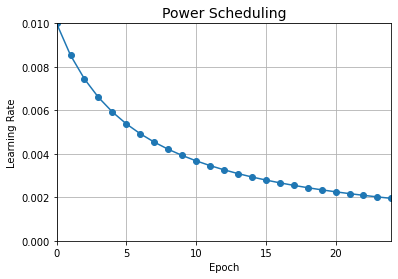

In [4]:
import math

n_epochs = 25
learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch) # n_steps_per_epoch = 1719

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
# 거듭제곱 스케줄링
# t : 스텝수 (가중치 업데이트 횟수)
# 𝜂_0: 초기 학습률
# c : 상수
# s : 학습률은 (c=1이라면) s번 스텝 뒤에 𝜂_0/2가 되고, s번 더 지나면 𝜂_0/3,…
# 구현은 키워드 인자 전달로 전달
# 케라스는 c=1과 s=1 / decay을 사용

In [7]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4847 - accuracy: 0.8305 - val_loss: 0.4226 - val_accuracy: 0.8564
Epoch 2/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3804 - accuracy: 0.8653 - val_loss: 0.3765 - val_accuracy: 0.8680
Epoch 3/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3470 - accuracy: 0.8755 - val_loss: 0.3605 - val_accuracy: 0.8766
Epoch 4/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3248 - accuracy: 0.8833 - val_loss: 0.3584 - val_accuracy: 0.8748
Epoch 5/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3088 - accuracy: 0.8899 - val_loss: 0.3484 - val_accuracy: 0.8814
Epoch 6/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2956 - accuracy: 0.8942 - val_loss: 0.3459 - val_accuracy: 0.8770
Epoch 7/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2851 - accuracy: 0.8982 - val_loss: 0.3370 - val_accuracy:

In [ ]:
# 지수 기반 스케줄링
# t=s일 때 𝜂_0의 0.1배, t=2s일 때 (0.1)^2배, t=3s일 때 (0.1)^3배 …
# s번의 스텝마다 10배씩 감소
# 구현은 LearningRateScheduler콜백 사용 (인자: 스케줄 함수)


In [8]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [9]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [15]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [ ]:
# LearningRateScheduler콜백 사용

In [16]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 30s 6ms/step - loss: 0.9423 - accuracy: 0.7357 - val_loss: 0.7411 - val_accuracy: 0.7802 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.7657 - accuracy: 0.7808 - val_loss: 0.6826 - val_accuracy: 0.8122 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.6859 - accuracy: 0.8081 - val_loss: 0.7859 - val_accuracy: 0.7288 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5964 - accuracy: 0.8227 - val_loss: 0.5942 - val_accuracy: 0.8344 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.5278 - accuracy: 0.8492 - val_loss: 0.5777 - val_accuracy: 0.8408 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4850 - accuracy: 0.8563 - val_loss: 0.5241 - val_accuracy: 0.8574 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================

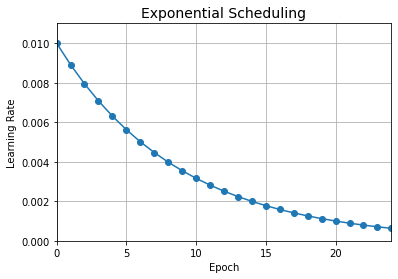

In [17]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
# 구간별 고정 스케줄링
# 일정 횟수의 에포크 동안 일정한 학습률을 사용하고, 
# 그 다음 또 다른 횟수의 에포크 동안은 더 작은 학습률을 사용하는 방식
# 스케줄러 함수를 정의하고 LearningRateScheduler콜백 사용

In [18]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [19]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])


In [20]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 15s 8ms/step - loss: 0.8781 - accuracy: 0.7483 - val_loss: 5.2010 - val_accuracy: 0.7144 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.8297 - accuracy: 0.7575 - val_loss: 0.7476 - val_accuracy: 0.8048 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.8784 - accuracy: 0.7479 - val_loss: 0.9547 - val_accuracy: 0.6906 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.8918 - accuracy: 0.7495 - val_loss: 0.7965 - val_accuracy: 0.7744 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.8821 - accuracy: 0.7345 - val_loss: 1.0567 - val_accuracy: 0.7278 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 13s 8ms/step - loss: 0.6215 - accuracy: 0.8041 - val_loss: 0.5923 - val_accuracy: 0.8250 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================

In [ ]:
# 성능 기반 스케줄링
# Validation Loss를 측정하고, 일정 횟수 동안 
# Loss가 줄어들지 않으면 특정한 배수 만큼 학습률을 감소시킵니다.
# ReduceLR0nPlateau콜백을 사용
# lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
# 5번의 연속적인 에포크 동안 향상이 없으면 학습률에 0.5를 곱함

In [21]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5905 - accuracy: 0.8054 - val_loss: 0.5490 - val_accuracy: 0.8330 - lr: 0.0200
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5069 - accuracy: 0.8369 - val_loss: 0.5026 - val_accuracy: 0.8410 - lr: 0.0200
Epoch 3/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5016 - accuracy: 0.8431 - val_loss: 0.4695 - val_accuracy: 0.8444 - lr: 0.0200
Epoch 4/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5286 - accuracy: 0.8431 - val_loss: 0.5639 - val_accuracy: 0.8334 - lr: 0.0200
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4940 - accuracy: 0.8520 - val_loss: 0.6033 - val_accuracy: 0.8490 - lr: 0.0200
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5028 - accuracy: 0.8569 - val_loss: 0.5549 - val_accuracy: 0.8506 - lr: 0.0200
Epoch 7/25
1719/1719 [==============================] - 7s

In [ ]:
# 1사이클 스케줄링
# 에포크가 아닌 매 스텝마다 업데이트

In [22]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))


Epoch 1/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4864 - accuracy: 0.8295 - val_loss: 0.4063 - val_accuracy: 0.8594
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3790 - accuracy: 0.8654 - val_loss: 0.3770 - val_accuracy: 0.8708
Epoch 3/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3453 - accuracy: 0.8781 - val_loss: 0.3620 - val_accuracy: 0.8694
Epoch 4/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3239 - accuracy: 0.8852 - val_loss: 0.3570 - val_accuracy: 0.8780
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3066 - accuracy: 0.8903 - val_loss: 0.3458 - val_accuracy: 0.8790
Epoch 6/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2937 - accuracy: 0.8960 - val_loss: 0.3456 - val_accuracy: 0.8814
Epoch 7/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2831 - accuracy: 0.8987 - val_loss: 0.3386 - val_accuracy: